# Benchmarking Baseline Classifiers

Although we've already went through each classifier in our tool belt, we'll get a consolidated report of the baseline models for each classifier, and output the results in a cohesive way.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, 
    GradientBoostingClassifier
)
from xgboost import XGBRFClassifier

from sklearn.metrics import plot_roc_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from src.seed import SEED

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load our data, split into training and testing sets
train = pd.read_csv("../data/processed/train.csv")

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [3]:
# Create dictionary of baseline classifiers
clfs = {
    "Logistic Regression": LogisticRegression(fit_intercept=False, solver="liblinear", random_state=SEED, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=SEED),
    "Random Forest": RandomForestClassifier(criterion="entropy", n_jobs=-1, random_state=SEED),
    "RF AdaBoost": AdaBoostClassifier(random_state=SEED),
    "RF Bagging": BaggingClassifier(n_jobs=-1, random_state=SEED),
    "RF GradientBoost": GradientBoostingClassifier(random_state=SEED),
    "RF XGBoost": XGBRFClassifier(n_jobs=-1, random_state=SEED),
}

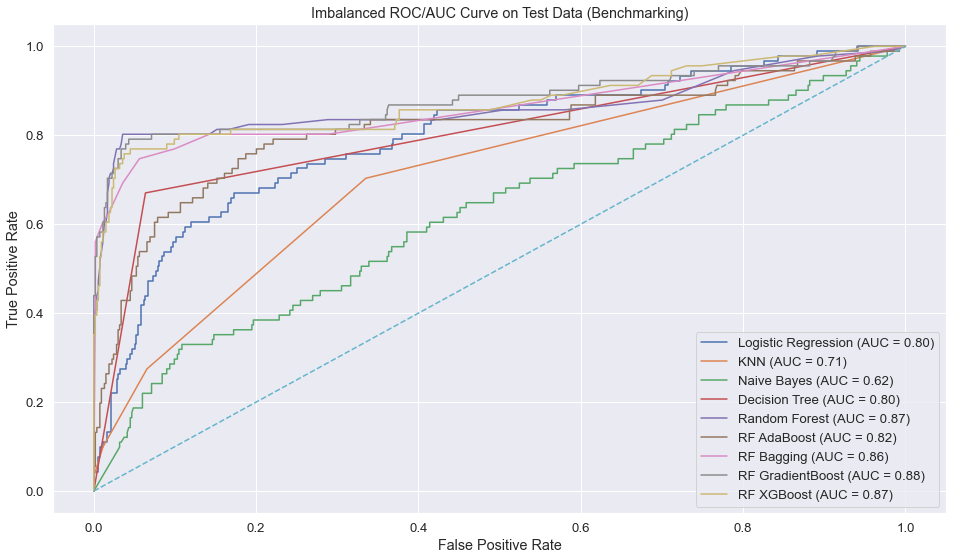

In [4]:
# train all models, get training f1 score plot roc_curve

fig, ax = plt.subplots(figsize=(16, 9))

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

results = []
for (model, clf) in clfs.items():
    # CV scoring of classifier
    cv_f1_score = cross_val_score(clf, X_train, y_train, scoring="f1", cv=skfold, n_jobs=-1).mean()
    # train classifier
    clf.fit(X_train, y_train)
    # make testing predictions
    test_pred = clf.predict(X_test)
    # f1 score on test data
    test_f1 = f1_score(y_test, test_pred)
    #plot roc/auc
    plot_roc_curve(clf, X_test, y_test, name=model, ax=ax)
    #append f1 results
    results.append([model, cv_f1_score, test_f1])

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Imbalanced ROC/AUC Curve on Test Data (Benchmarking)")
plt.show()

In [5]:
# dataframe of cv and test f1 scores, sorted by best test f1 score
scores = pd.DataFrame(results, columns=["classifier", "cv_f1", "test_f1"])
scores.sort_values("test_f1", ascending=False)

,classifier,cv_f1,test_f1
7,RF GradientBoost,0.819926,0.773006
8,RF XGBoost,0.788959,0.743902
6,RF Bagging,0.753963,0.723926
4,Random Forest,0.645130,0.661972
3,Decision Tree,0.705351,0.655914
5,RF AdaBoost,0.447796,0.429630
0,Logistic Regression,0.382403,0.392857
2,Naive Bayes,0.282586,0.267420
1,KNN,0.097866,0.169811


On our class imbalanced data, we see that the baseline classifier that performs the best is our Random Forest Gradient Boosted. It has both the highest AUC score of .88, meaning it has a high degree of separability between classes. It also compared to other baseline classifiers has the best f1 score on both training and testing data, meaning it doesn't overfit our data.

In [6]:
# account for class imbalance
sm = SMOTENC(np.arange(19, 69), n_jobs=-1, random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

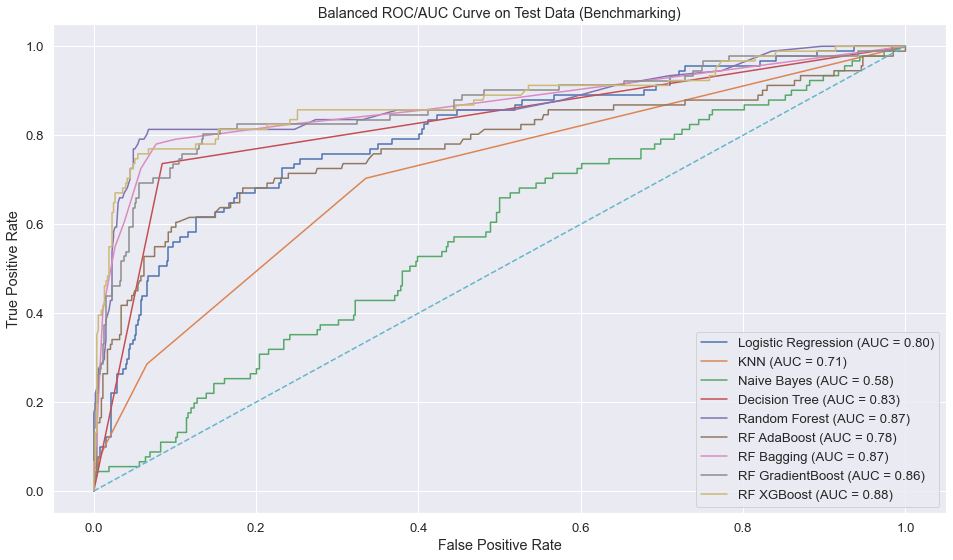

In [7]:
# train all models, get training f1 score plot roc_curve

fig, ax = plt.subplots(figsize=(16, 9))

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

results = []
for (model, clf) in clfs.items():
    # CV scoring of classifier
    cv_f1_score = cross_val_score(clf, X_train, y_train, scoring="f1", cv=skfold, n_jobs=-1).mean()
    # train classifier
    clf.fit(X_train, y_train)
    # make testing predictions
    test_pred = clf.predict(X_test)
    # f1 score on test data
    test_f1 = f1_score(y_test, test_pred)
    #plot roc/auc
    plot_roc_curve(clf, X_test, y_test, name=model, ax=ax)
    #append f1 results
    results.append([model, cv_f1_score, test_f1])

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Balanced ROC/AUC Curve on Test Data (Benchmarking)")
plt.show()

In [8]:
# dataframe of cv and test f1 scores, sorted by best test f1 score
scores = pd.DataFrame(results, columns=["classifier", "cv_f1", "test_f1"])
scores.sort_values("test_f1", ascending=False)

,classifier,cv_f1,test_f1
4,Random Forest,0.960314,0.711864
8,RF XGBoost,0.907472,0.711340
6,RF Bagging,0.940740,0.702128
7,RF GradientBoost,0.935216,0.684783
3,Decision Tree,0.926132,0.660099
5,RF AdaBoost,0.882383,0.544444
0,Logistic Regression,0.807133,0.387755
1,KNN,0.907865,0.168224
2,Naive Bayes,0.873944,0.150000


When accounting for class imbalance, we see all our models perform exceedingly well in training, with f1 scores over 80%. However we see our test f1 scores are lackluster, and our top performer doesn't do as well as our imbalanced RF Gradient Boost model. We also see that when training on balanced data, the model which has the highest degree of separability is our XGBoost Random Forest classifier, but this model under performs.